# Emissões de $CO_{2}$ por veículos

**Grupo 04:**
*   Adriano Gambetta
*   Emanuelle Lemos
*   João Pedro Bueno
*   Manuel Castro
*   Mike Valente
*   Pedro Marques

## INICIANDO O PROJETO

**Carregando as bibliotecas**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

**Carregando o conjunto de dados**

In [ ]:
data = pd.read_csv('dados/CO2 Emissions_Canada.csv', sep=',')

rename_columns = {
    'Make': "make",
    'Model': "model",
    'Vehicle Class': "vehicle_class",
    'Engine Size(L)': "engine_size",
    'Cylinders': "cylinders",
    'Transmission': "transmission",
    'Fuel Type': "fuel_type",
    'Fuel Consumption City (L/100 km)': "fuel_cons_city",
    'Fuel Consumption Hwy (L/100 km)': "fuel_cons_hwy",
    'Fuel Consumption Comb (L/100 km)': "fuel_cons_comb",
    'Fuel Consumption Comb (mpg)': "fuel_cons_comb_mpg",
    'CO2 Emissions(g/km)': "co2",
}

data = data.rename(columns=rename_columns)

## Definindo o problema

Nosso conjunto de dados representa a quantidade de $CO_{2}$ (em gramas por km) emitida por 7385 modelos de carros, em dados coletados pelo governo do Canadá, compilados por um período de 7 anos.

Entre as _features_ consideradas estão variáveis categóricas que descrevem marca, modelos, classe do veículo, etc., e algumas variáveis numéricas, sendo uma discreta (número de cilindros) e as demais contínuas. 

O problema de prever as emissões a partir das características do veículo é um problema de regressão, pois temos uma variável alvo contínua. A correlação entre as variáveis relativas ao consumo de combustível e o _target_ (emissão de $CO_{2}$) é evidente, mas nota-se a interferência significativa de uma variável categórica, o tipo de combustível.

Para abordar o problema fizemos uma modelagem usando as classes LinearRegression e RandomForestRegressor do scikit-learn e comparamos suas métricas.

Fonte do dataset: https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles.

## ANÁLISE E EXPLORAÇÃO DOS DADOS


**Identificando os tipos de dados**

In [ ]:
data.dtypes

make                   object
model                  object
vehicle_class          object
engine_size           float64
cylinders               int64
transmission           object
fuel_type              object
fuel_cons_city        float64
fuel_cons_hwy         float64
fuel_cons_comb        float64
fuel_cons_comb_mpg      int64
co2                     int64
dtype: object

In [ ]:
data.describe()

,engine_size,cylinders,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,fuel_cons_comb_mpg,co2
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,27.481652,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,7.231879,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,32.000000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


In [ ]:
# não existem valores nulos 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make                7385 non-null   object 
 1   model               7385 non-null   object 
 2   vehicle_class       7385 non-null   object 
 3   engine_size         7385 non-null   float64
 4   cylinders           7385 non-null   int64  
 5   transmission        7385 non-null   object 
 6   fuel_type           7385 non-null   object 
 7   fuel_cons_city      7385 non-null   float64
 8   fuel_cons_hwy       7385 non-null   float64
 9   fuel_cons_comb      7385 non-null   float64
 10  fuel_cons_comb_mpg  7385 non-null   int64  
 11  co2                 7385 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 692.5+ KB


**Verificando dados não numéricos**

In [ ]:
len(set(data.make))

42

In [ ]:
len(set(data.model))

2053

In [ ]:
data.vehicle_class.value_counts()

SUV - SMALL                 1217
MID-SIZE                    1133
COMPACT                     1022
SUV - STANDARD               735
FULL-SIZE                    639
SUBCOMPACT                   606
PICKUP TRUCK - STANDARD      538
TWO-SEATER                   460
MINICOMPACT                  326
STATION WAGON - SMALL        252
PICKUP TRUCK - SMALL         159
MINIVAN                       80
SPECIAL PURPOSE VEHICLE       77
VAN - PASSENGER               66
STATION WAGON - MID-SIZE      53
VAN - CARGO                   22
Name: vehicle_class, dtype: int64

In [ ]:
data.transmission.value_counts()

AS6     1324
AS8     1211
M6       901
A6       789
A8       490
AM7      445
A9       339
AS7      319
AV       295
M5       193
AS10     168
AM6      132
AV7      118
AV6      113
M7        91
A5        84
AS9       77
A4        65
AM8       62
A7        53
AV8       39
A10       31
AS5       26
AV10      11
AM5        4
AM9        3
AS4        2
Name: transmission, dtype: int64

In [ ]:
data.fuel_type.value_counts()

X    3637
Z    3202
E     370
D     175
N       1
Name: fuel_type, dtype: int64

**Verificando a correlação entre os dados numéricos**

Obs.: Exceto *fuel_cons_comb_mpg* que corresponde a feature *fuel_cons_comb* em outra unidade de medida.

In [ ]:
data_numerical = data[['engine_size', 'cylinders', 'fuel_cons_city', 'fuel_cons_hwy', 'fuel_cons_comb', 'co2']]

In [ ]:
corr_data = data_numerical.corr()

<AxesSubplot:>

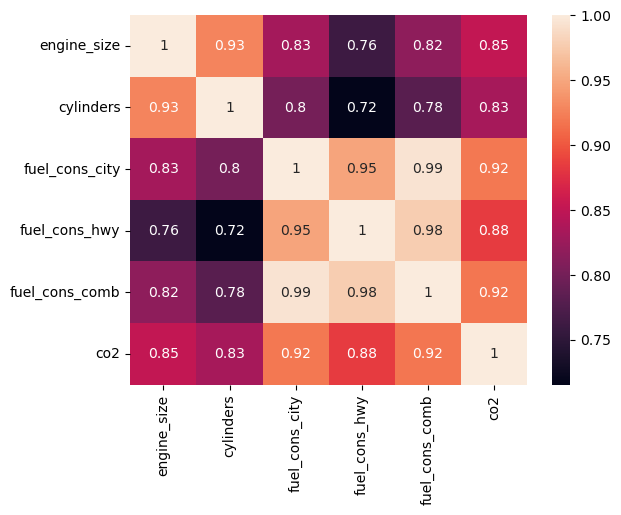

In [ ]:
sns.heatmap(data=corr_data, annot=True)

In [ ]:
corr_data['co2'].sort_values(ascending = False)

co2               1.000000
fuel_cons_city    0.919592
fuel_cons_comb    0.918052
fuel_cons_hwy     0.883536
engine_size       0.851145
cylinders         0.832644
Name: co2, dtype: float64

Vemos que a maior correlação é com o consumo na cidade. A segunda maior, porém, já é uma coluna que leva em consideração o consumo na cidade e na estrada, então não nos traz informação adicional; ademais, a coluna fuel_cons_comb_mpg é apenas a conversão desta (fuel_cons_comb) para uma unidade invertida (milhas por galão, ao invés de L/100km), por isso ela tem forte correlação negativa, mas também não nos ajuda na construção de um modelo.

In [ ]:
data.drop(columns=['fuel_cons_comb', 'fuel_cons_comb_mpg'], inplace=True)
data.head()

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_cons_city,fuel_cons_hwy,co2
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,244


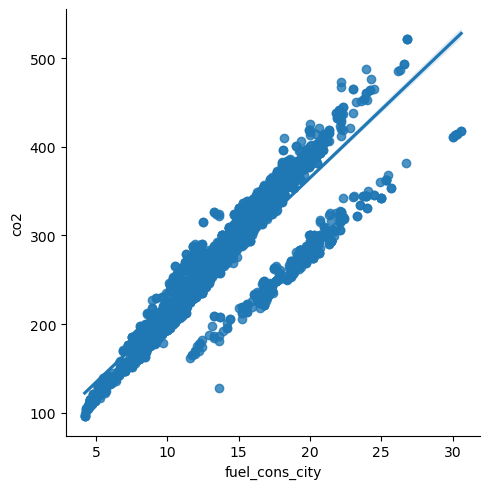

In [ ]:
sns.lmplot(x='fuel_cons_city', y='co2', data=data)

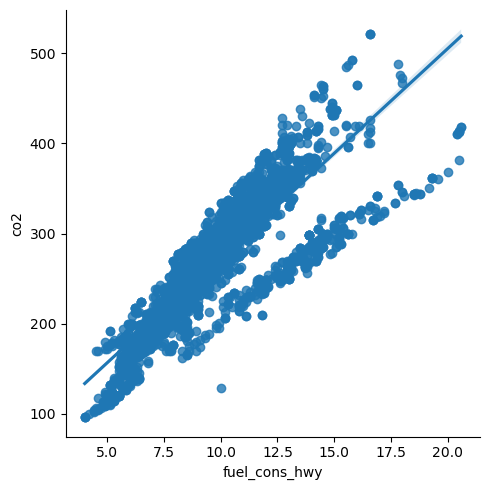

In [ ]:
sns.lmplot(x='fuel_cons_hwy', y='co2', data=data)

Fazendo a regressão linear apenas com os dados de consumo, apesar de termos boas correlações, vemos que há uma separação nítida dos dados em certos patamares, indicando que há um outro fator importante, que é o tipo de combustível. Vejamos:

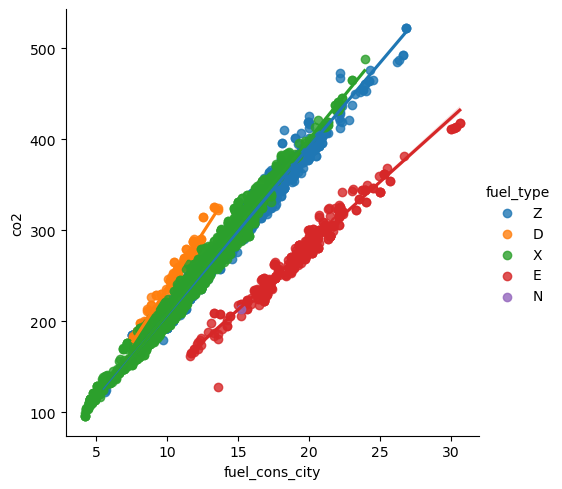

In [ ]:
sns.lmplot(x='fuel_cons_city', y='co2', data=data, hue='fuel_type')

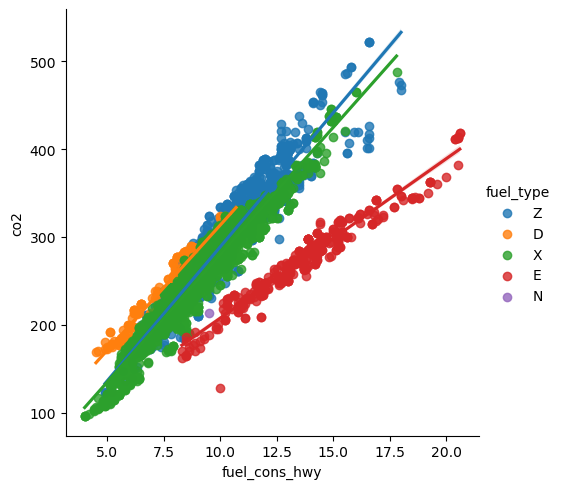

In [ ]:
sns.lmplot(x='fuel_cons_hwy', y='co2', data=data, hue='fuel_type')

## PREPARAÇÃO DOS DADOS

Gerando categóricas para o tipo de combustível e incluindo nos dados numéricos

In [ ]:
fuel_dummies = pd.get_dummies(data['fuel_type'], drop_first = True)
model_data = pd.concat([data_numerical, fuel_dummies], axis = 1)
model_data.head()

,engine_size,cylinders,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,co2,E,N,X,Z
0,2.0,4,9.9,6.7,8.5,196,0,0,0,1
1,2.4,4,11.2,7.7,9.6,221,0,0,0,1
2,1.5,4,6.0,5.8,5.9,136,0,0,0,1
3,3.5,6,12.7,9.1,11.1,255,0,0,0,1
4,3.5,6,12.1,8.7,10.6,244,0,0,0,1


Removendo a coluna 'fuel_cons_comb' dos dados do modelo

In [ ]:
model_data.drop(columns = 'fuel_cons_comb', inplace = True)

## MODELAGEM


**Problema de Regressão** - Random Forest vs. Regressão Linear

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#### 2. Instanciar a classe do estimador, **escolhendo os hiperparâmetros desejados**
- Para a primeira versão do modelo, pode ser uma boa escolha utilizar os parâmetros default;
- Veremos mais pra frente como escolher os hiperparâmetros adequadamente;

In [ ]:
random_forest = RandomForestRegressor(n_estimators=1000, max_features=0.3)
lin_reg = LinearRegression()

#### 3. Separe os dados em **dados de treino** e **dados de teste**.

In [ ]:
X = model_data.drop(columns='co2')
y = model_data['co2']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X_train.head()

,engine_size,cylinders,fuel_cons_city,fuel_cons_hwy,E,N,X,Z
6590,3.0,6,11.4,8.1,0,0,0,1
6274,4.0,6,14.7,10.3,0,0,1,0
2251,3.0,6,13.8,9.0,0,0,0,1
3149,3.4,6,11.3,7.9,0,0,0,1
4362,2.0,4,10.1,7.0,0,0,0,1


#### 4. Treine o modelo, usando **os dados de treino**

In [ ]:
random_forest.fit(X_train, y_train)
lin_reg.fit(X_train, y_train)

LinearRegression()

#### 5. Use o modelo treinado para **fazer previsões** usando os **dados de teste** (ou **de validação**)

In [ ]:
rf_prediction = random_forest.predict(X_test)
lr_prediction = lin_reg.predict(X_test)

#### 6. **Avalie a performance do modelo com base nas previsões acima**

Lembre que você pode treinar e avaliar muito modelos, e no final escolher aquele que teve melhor performance respeito à metrica escolhida.

**Métricas de avaliação:**

In [ ]:
print('Métricas do Random Forest:')
print('R²:', metrics.r2_score(y_test, rf_prediction))
print('MAE:', metrics.mean_absolute_error(y_test, rf_prediction))
print('MSE:', metrics.mean_squared_error(y_test, rf_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_prediction)))

print('\nMétricas do Linear Regression:')
print('R²:', metrics.r2_score(y_test, lr_prediction))
print('MAE:', metrics.mean_absolute_error(y_test, lr_prediction))
print('MSE:', metrics.mean_squared_error(y_test, lr_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lr_prediction)))

Métricas do Random Forest:
R²: 0.9965178734205724
MAE: 1.869766531221594
MSE: 11.977218043475114
RMSE: 3.4608117607687237

Métricas do Linear Regression:
R²: 0.9884108794129784
MAE: 3.22389905797943
MSE: 39.862256881454805
RMSE: 6.313656379741837


**Visualização gráfica dos valores reais x valores preditos**

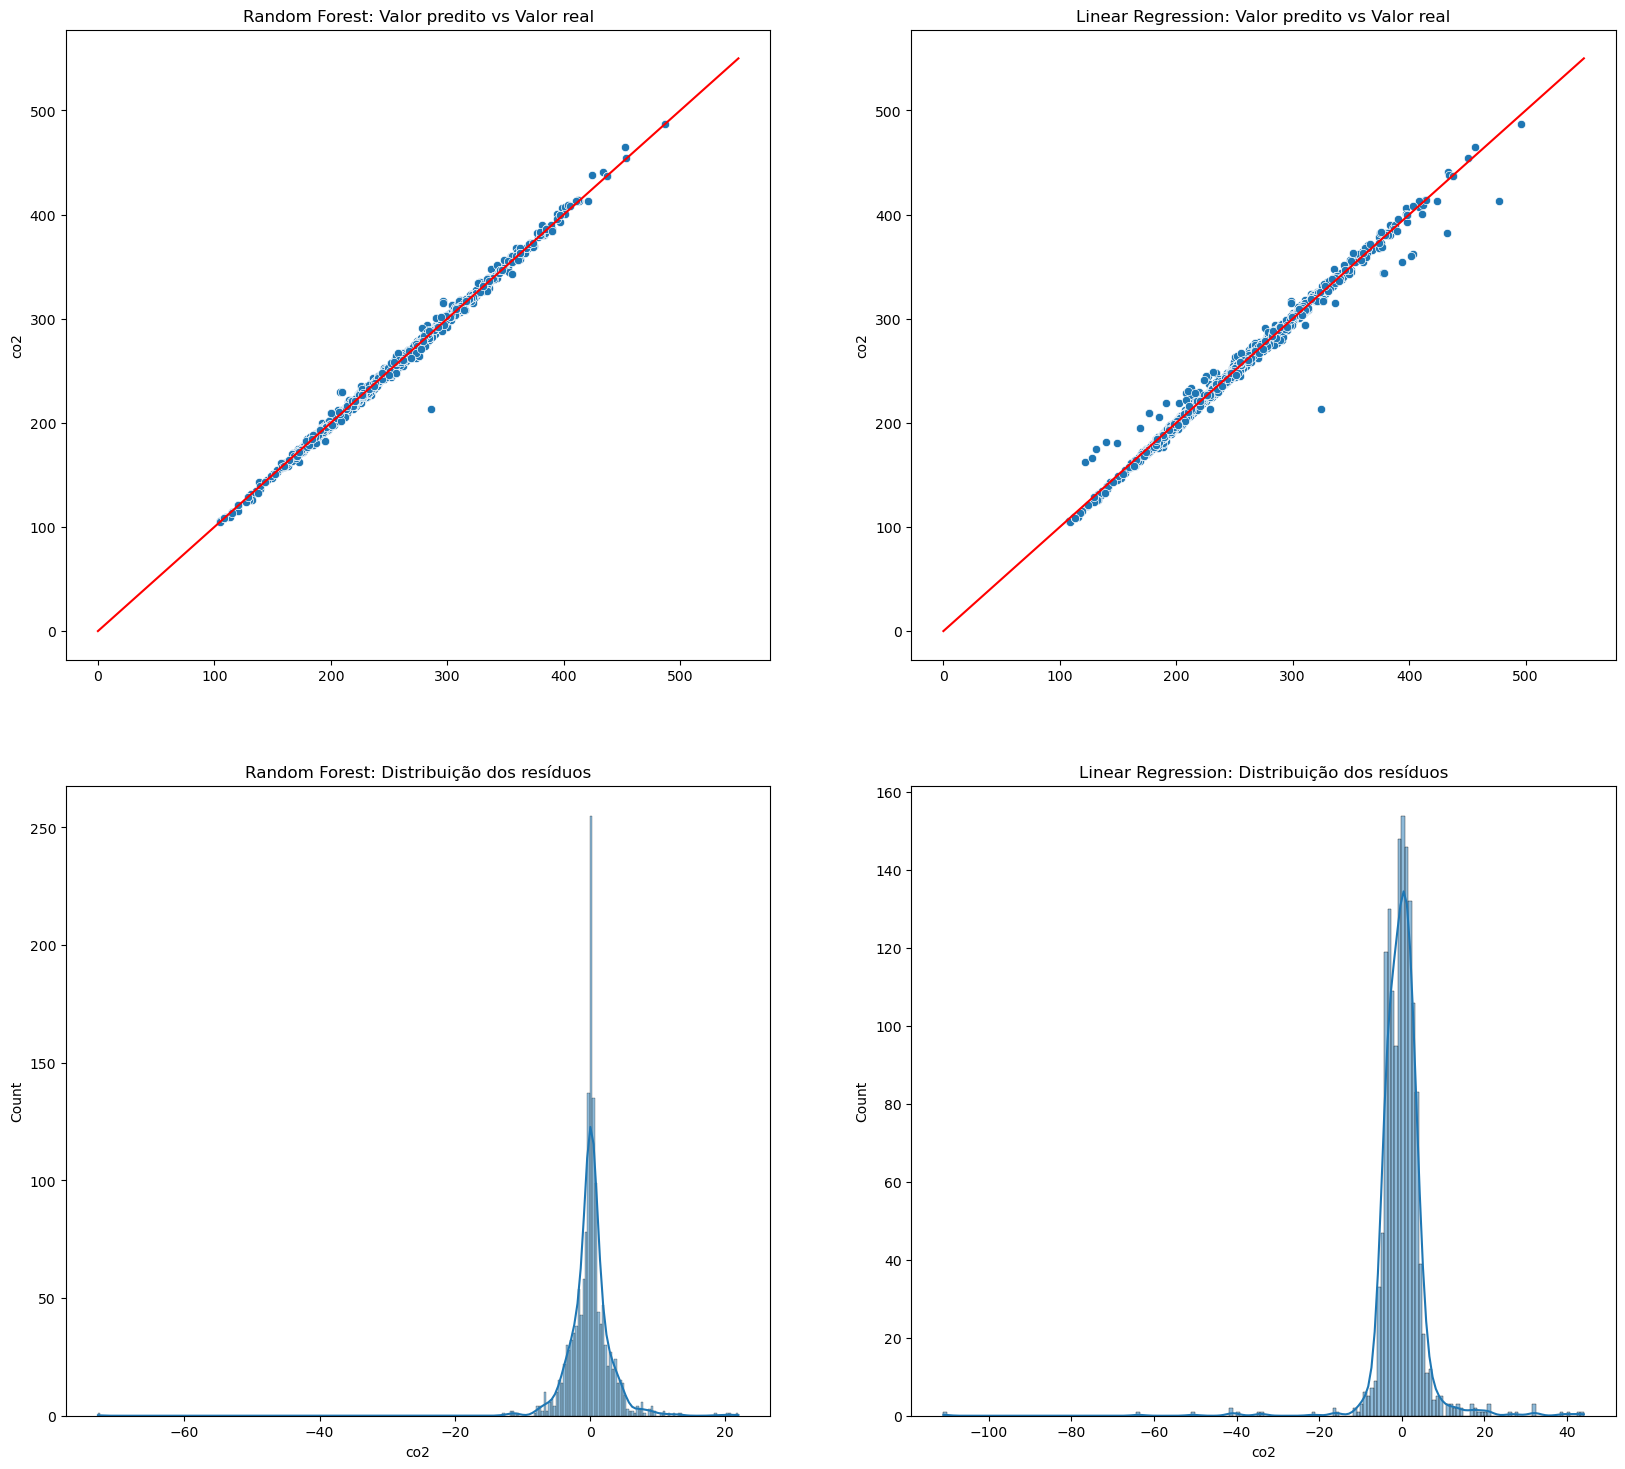

In [ ]:
figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))

plt.subplot(2, 2, 1)
plt.title("Random Forest: Valor predito vs Valor real")
sns.scatterplot(x=rf_prediction, y=y_test)
x = np.linspace(0, 550, 10000)
y = x
plt.plot(x, y, color="red")

plt.subplot(2, 2, 3)
plt.title("Random Forest: Distribuição dos resíduos")
sns.histplot(y_test-rf_prediction, kde=True)

plt.subplot(2, 2, 2)
plt.title("Linear Regression: Valor predito vs Valor real")
sns.scatterplot(x=lr_prediction, y=y_test)
x = np.linspace(0, 550, 10000)
y = x
plt.plot(x, y, color="red")

plt.subplot(2, 2, 4)
plt.title("Linear Regression: Distribuição dos resíduos")
sns.histplot(y_test-lr_prediction, kde=True)
plt.show()


**Feature importance**

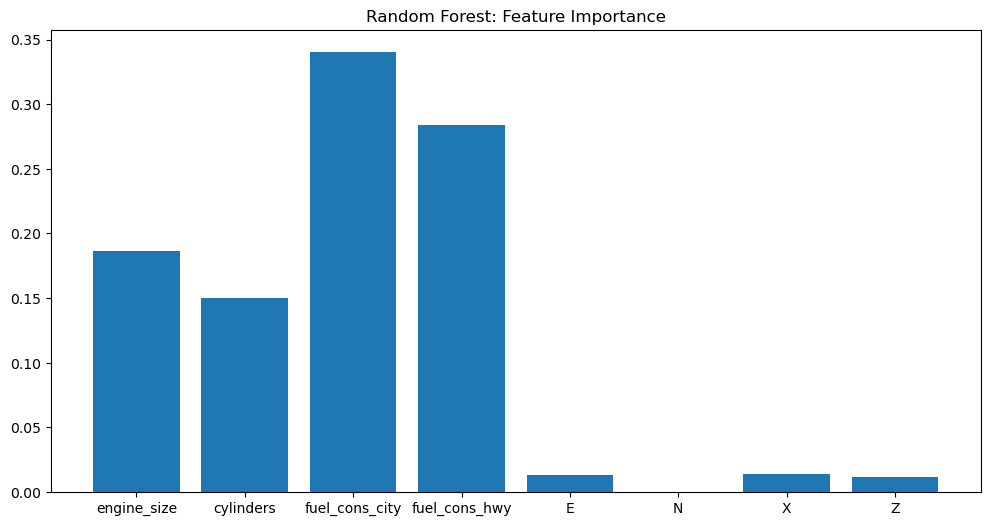

In [ ]:
fig_bar, ax_bar = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plt.title('Random Forest: Feature Importance')
importance = random_forest.feature_importances_
var_names = X_train.columns.to_list()

ax_bar.bar(var_names, importance)
plt.show()

Fica claro que o modelo Random Forest é superior ao Linear Regression neste caso


### Análise de Overfitting - Random Forest

In [ ]:
results = {"num_features" : [],
              "r2_train" : [],
              "r2_test" : [],
              "mae_train" : [],
              "mae_test" : [],
              "mse_train" : [],
              "mse_test" : [],
              "rmse_train" : [],
              "rmse_test" : [],
           }

In [ ]:
def train_test_metrics(dados):
  X = dados.drop(columns='co2')
  y = dados['co2']
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42
  )

  random_forest = RandomForestRegressor(n_estimators=1000, max_features=0.3)
  random_forest.fit(X_train, y_train)

  rf_pred_train = random_forest.predict(X_train)
  rf_pred_test = random_forest.predict(X_test)

  # métricas de treino
  r2_train = metrics.r2_score(y_train, rf_pred_train)
  mae_train = metrics.mean_absolute_error(y_train, rf_pred_train)
  mse_train = metrics.mean_squared_error(y_train, rf_pred_train)
  rmse_train = np.sqrt(metrics.mean_squared_error(y_train, rf_pred_train))

  # métricas de teste
  r2_test = metrics.r2_score(y_test, rf_pred_test)
  mae_test = metrics.mean_absolute_error(y_test, rf_pred_test)
  mse_test = metrics.mean_squared_error(y_test, rf_pred_test)
  rmse_test = np.sqrt(metrics.mean_squared_error(y_test, rf_pred_test))

  return r2_train, mae_train, mse_train, rmse_train, r2_test, mae_test, mse_test, rmse_test

**Testando com duas, quatro e oito features**

In [ ]:
colunas_desejadas = [
    ['fuel_cons_city', 'fuel_cons_hwy', 'co2'],
    ['engine_size', 'cylinders', 'fuel_cons_city', 'fuel_cons_hwy', 'co2'],
    ['engine_size', 'cylinders', 'fuel_cons_city', 'fuel_cons_hwy', 'E', 'N', 'X', 'Z', 'co2']
]

for cols in colunas_desejadas:
  dados = model_data[cols]
  r2_train, mae_train, mse_train, rmse_train, r2_test, mae_test, mse_test, rmse_test = train_test_metrics(dados)

  results['num_features'].append(len(cols) - 1)
  results['r2_train'].append(r2_train)
  results['mae_train'].append(mae_train)
  results['mse_train'].append(mse_train)
  results['rmse_train'].append(rmse_train)
  results['r2_test'].append(r2_test)
  results['mae_test'].append(mae_test)
  results['mse_test'].append(mse_test)
  results['rmse_test'].append(rmse_test)

In [ ]:
df_results = pd.DataFrame(results)

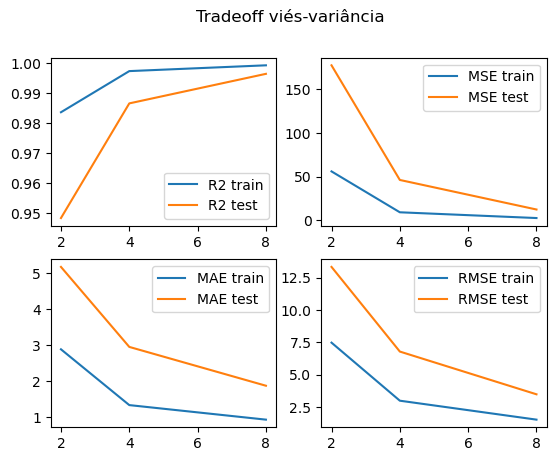

In [ ]:
plt.suptitle("Tradeoff viés-variância")

plt.subplot(2, 2, 1)
plt.plot(df_results["num_features"], df_results["r2_train"], label="R2 train")
plt.plot(df_results["num_features"], df_results["r2_test"], label="R2 test")
plt.legend(loc="lower right") 

plt.subplot(2, 2, 3)
plt.plot(df_results["num_features"], df_results["mae_train"], label="MAE train")
plt.plot(df_results["num_features"], df_results["mae_test"], label="MAE test")
plt.legend(loc="upper right") 

plt.subplot(2, 2, 2)
plt.plot(df_results["num_features"], df_results["mse_train"], label="MSE train")
plt.plot(df_results["num_features"], df_results["mse_test"], label="MSE test")
plt.legend(loc="upper right") 

plt.subplot(2, 2, 4)
plt.plot(df_results["num_features"], df_results["rmse_train"], label="RMSE train")
plt.plot(df_results["num_features"], df_results["rmse_test"], label="RMSE test")
plt.legend(loc="upper right") 

plt.legend()
plt.show()